In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/data/work/jiaqi/targetdiff


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import utils.misc as misc
from datasets import get_dataset
from tqdm.auto import tqdm
import os
import pickle

## load data

In [4]:
with open('data/affinity_info.pkl', 'rb') as f:
    affinity_info = pickle.load(f)

In [5]:
results = torch.load('outputs_embedding/crossdocked_train.pt')
test_results = torch.load('outputs_embedding/crossdocked_test.pt')
# pdbbind_results = torch.load('outputs_embedding/pdbbind_v2020_all.pt')
print(len(results), len(test_results))

40617 27


In [7]:
config = misc.load_config('configs/training.yml')
dataset, subsets = get_dataset(
    config=config.data,
    transform=None,
)
train_set, val_set = subsets['train'], subsets['test']

In [8]:
# add protein / ligand fn
for r in tqdm(results):
    data = train_set[r['idx']]
    r['protein_fn'] = data.protein_filename
    r['ligand_fn'] = data.ligand_filename

  0%|          | 0/40617 [00:00<?, ?it/s]

In [9]:
# split data
def get_pdb_name(fn):
    return os.path.basename(fn)[:4]

def get_ligand_name(fn):
    return os.path.basename(fn)[:4]

def get_unique_pockets(dataset, raw_id, used_pdb, num_pockets):
    # only save first encountered id for unseen pdbs
    unique_id = []
    pdb_visited = set()
    for idx in tqdm(raw_id, 'Filter'):
        pdb_name = get_pdb_name(dataset[idx].ligand_filename)
        if pdb_name not in used_pdb and pdb_name not in pdb_visited:
            unique_id.append(idx)
            pdb_visited.add(pdb_name)

    print('Number of Pairs: %d' % len(unique_id))
    print('Number of PDBs:  %d' % len(pdb_visited))

    random.Random(args.seed).shuffle(unique_id)
    unique_id = unique_id[:num_pockets]
    print('Number of selected: %d' % len(unique_id))
    return unique_id, pdb_visited.union(used_pdb)


In [10]:
all_pdb = {get_pdb_name(d['protein_fn']) for d in results}
test_pdb = list(np.random.choice(list(all_pdb), 1000, replace=False))
test_idx = [idx for idx, r in enumerate(results) if get_pdb_name(r['protein_fn']) in test_pdb]
train_idx = list(set(range(len(results))) - set(test_idx))
print(f'train size: {len(train_idx)} test size: {len(test_idx)}')


train size: 35801 test size: 4816


In [11]:
train_results = [results[idx] for idx in train_idx]
test_results = [results[idx] for idx in test_idx]

In [12]:
for k, v in train_results[0].items():
    if torch.is_tensor(v):
        print(k, v.shape)

kl_pos torch.Size([11])
kl_v torch.Size([11])
pred_ligand_v torch.Size([31, 13])
final_h torch.Size([405, 128])
final_ligand_h torch.Size([31, 128])


## feats vs. pK

In [13]:
def extract_features(all_results):
    vina = np.array([r['vina'] for r in all_results])
        
    kl_pos = np.array([r['kl_pos'].numpy() for r in all_results])
    kl_v = np.array([r['kl_v'].numpy() for r in all_results])
    
    nll_pos = np.array([r['kl_pos'][1:].numpy().mean() for r in all_results])
    nll_v = np.array([r['kl_v'].numpy().mean() for r in all_results])
    nll_all = np.array([(r['kl_pos'][1:] + 100 * r['kl_v'][1:]).numpy().mean() for r in all_results])
    
    entropy_v_all = [stats.entropy(torch.softmax(r['pred_ligand_v'], dim=-1).numpy(), axis=-1) for r in all_results]
    num_atoms = [e.shape[0] for e in entropy_v_all]
    entropy_v_mean = [e.mean() for e in entropy_v_all]
    entropy_v_mean_norm = [e.mean() / e.shape[0] for e in entropy_v_all]

    return {
        'vina': vina,
        'kl_pos': kl_pos,
        'kl_v': kl_v,
        'nll_pos': nll_pos,
        'nll_v': nll_v,
        'nll_all': nll_all,
        
        'entropy_v_all': entropy_v_all,
        'num_atoms': num_atoms,
        'entropy_v_mean': entropy_v_mean,
        'entropy_v_mean_norm': entropy_v_mean_norm
    }

In [14]:
def norm_score(score, mode='mean-std'):
    if mode == 'min-max':
        score_norm = (score - score.min()) / (score.max() - score.min())
    elif mode == 'mean-std':
        score_norm = (score - score.mean()) / score.std()
    else:
        raise NotImplementedError
    return score_norm

In [15]:
def plot_reg(x, y, xlabel='x', ylabel='y'):
    r, p = stats.spearmanr(x, y)
    sns.regplot(x=x, y=y, line_kws = {'label': 'Spearman $r=%.2f$ \n $p$-value$=%.2e$' % (r, p)})
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [16]:
train_pk = np.array([r['pk'] for r in train_results])
test_pk = np.array([r['pk'] for r in test_results])

In [17]:
train_feat = extract_features(train_results)
test_feat = extract_features(test_results)

In [18]:
def plot_multi_reg(x_dict, y, ylabel='pk'):
    fig, axs = plt.subplots(1, len(x_dict), sharey=True, figsize=(8, 4))
    for i, (xlabel, x) in enumerate(x_dict.items()):
        ax = axs[i]
        r, p = stats.spearmanr(x, y)
        # sns.regplot(x=x, y=y, line_kws = {'label': 'Spearman $r=%.2f$ \n $p$-value$=%.2e$' % (r, p)})
        sns.regplot(x=x, y=y, ax=ax, 
                    line_kws = {'label': 'Spearman r=%.2f \n p-value=%.2e' % (r, p)})
        ax.set(xlabel=xlabel, ylabel=ylabel if i == 0 else None, xticks=[])
        
        ax.legend()
 

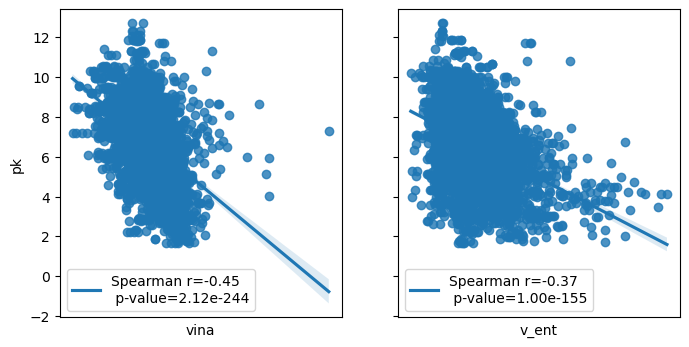

In [19]:
plot_multi_reg({'vina': test_feat['vina'], 
                'v_ent': np.array([np.max(e) / e.shape[0] for e in test_feat['entropy_v_all']])
               }, test_pk)

## supervised learning

In [20]:
from sklearn import linear_model

In [21]:
def pred_with_linear_regression(train_x, train_y, test_x, test_y, return_model=False):
    reg = linear_model.Ridge(alpha=.0)
    reg.fit(train_x, train_y)
    y_pred = reg.predict(test_x)
    print(stats.spearmanr(y_pred, test_y))
    if return_model:
        return y_pred, reg
    else:
        return y_pred
    

In [22]:
train_score1 = norm_score(train_feat['vina'])
train_score2 = np.array([np.max(e) / e.shape[0] for e in train_feat['entropy_v_all']])
test_score1 = norm_score(test_feat['vina'])
test_score2 = np.array([np.max(e) / e.shape[0] for e in test_feat['entropy_v_all']])

combine_pk_pred = pred_with_linear_regression(
    train_x=np.stack([train_score1, train_score2], -1),
    train_y=train_pk,
    test_x=np.stack([test_score1, test_score2], -1),
    test_y=test_pk
)

SpearmanrResult(correlation=0.4830945316508549, pvalue=3.633296534466661e-280)


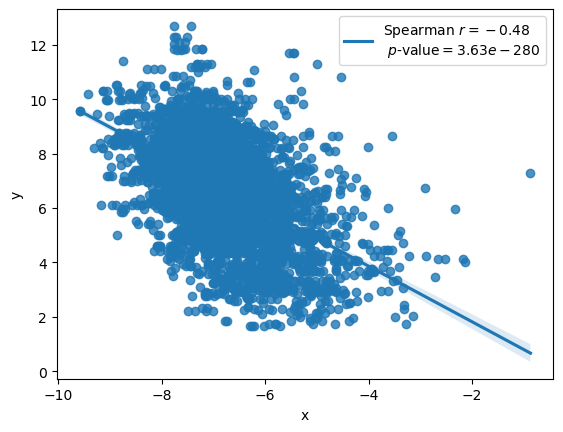

In [23]:
plot_reg(-combine_pk_pred, test_pk)

In [24]:
final_ligand_h = np.array([r['final_ligand_h'].numpy().mean(0) for r in train_results])
test_final_ligand_h = np.array([r['final_ligand_h'].numpy().mean(0) for r in test_results])
h_pk_pred, lmodel = pred_with_linear_regression(
    train_x=final_ligand_h,
    train_y=train_pk,
    test_x=test_final_ligand_h,
    test_y=test_pk,
    return_model=True
)

SpearmanrResult(correlation=0.6992587694053006, pvalue=0.0)


In [26]:
with open('pk_reg_para.pkl', 'wb') as f:
    pickle.dump(lmodel, f)

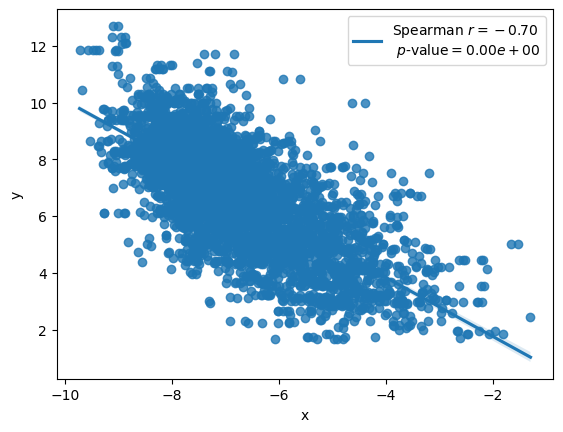

In [25]:
plot_reg(-h_pk_pred, test_pk)

In [27]:
def plot_multi_reg(x_dict, y, ylabel='pk'):
    fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8, 6))
    for i, (xlabel, x) in enumerate(x_dict.items()):
        ax = axs[i // 2][i % 2]
        r, p = stats.spearmanr(x, y)
        # sns.regplot(x=x, y=y, line_kws = {'label': 'Spearman $r=%.2f$ \n $p$-value$=%.2e$' % (r, p)})
        sns.regplot(x=x, y=y, ax=ax, 
                    scatter_kws={'alpha':0.3},
                    line_kws = {'label': '$r=%.2f$' % (r)})
        ax.set_xlabel(xlabel, fontsize=16)
        ax.set_ylabel(ylabel if i % 2 == 0 else None, fontsize=16)
        ax.set_xticks([])
        
        ax.legend(fontsize=16)
    plt.tight_layout()
    return fig

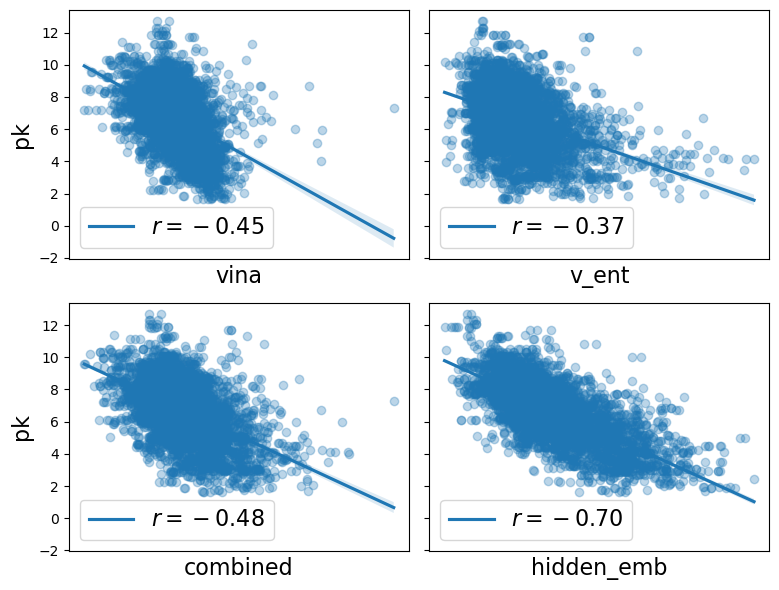

In [28]:
fig = plot_multi_reg({
    'vina': test_feat['vina'], 
    'v_ent': np.array([np.max(e) / e.shape[0] for e in test_feat['entropy_v_all']]),
    'combined': -combine_pk_pred,
    'hidden_emb': -h_pk_pred
}, test_pk)